In [1]:
import sys
sys.path.append("..")

# basics
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import copy
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import utils.floquet_solver as fsolver
import pulse.tanh as tanh
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm

pass

In [53]:
results = []

In [63]:
# Start with a pulse data from landscapes/FlatTop
# data selected so that we start on first fringe

# Need to generate plot and look for abrupt changes in duration or fidelity
# Generate fidelity landscapes at those changes to determine where the fringe is
# Rerun with manually set initial conditions

#amplitude 7.034040495797981 duration 146.17831127951132 offset 0.10188603062894215 fidelity 0.9963395703564574

initial_duration = super_results[0]["duration"]
initial_offset = super_results[0]["offset"]
initial_amplitude = super_results[0]["amplitude"]
final_amplitude = initial_amplitude/2
steps = 50
amplitudes_to_run = np.linspace(initial_amplitude, final_amplitude, steps)
# fidelity_threshold = 0.99999
ramp_coef = 0.5
cut_factor = 3

def cost(parameters, constants):
    global last_offset, last_duration
    duration = parameters[0]
    offset = parameters[1]
    amplitude = constants[0]
    freq = system.first_energy_spacing/3 - offset
    tlist = np.arange(0, duration, (2*np.pi)/(freq*20))
    tanh.setup(amplitude, freq, ramp_coef, cut_factor, tlist)
    s = fsolver.time_evolve(system.H0, system.H1, tanh, 16, 16, (2*np.pi)/freq, tlist, system.starting_state)
    # s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=False)
    fidelity = expv.expectation_value(s.final_state, system.target_state)
    # graph.graph_solution(s, system)
    # if fidelity > fidelity_threshold:
    #     results.append({
    #         "amplitude": amplitude,
    #         "offset": offset,
    #         "duration": duration,
    #         "fidelity": fidelity,
    #         "end_early": True
    #     })
    #     last_duration = duration
    #     last_offset = offset
    #     # print("amplitude", amplitude, "duration", duration, "offset", offset, "fidelity", fidelity)
    #     raise RuntimeError

    return (1 - fidelity)

last_duration = initial_duration
last_offset = initial_offset
for amplitude in tqdm(amplitudes_to_run):
    # try:
    result = scipy.optimize.minimize(cost, [last_duration, last_offset], [amplitude], method="Nelder-Mead", options={"disp":False})
    results.append({
        "amplitude": amplitude,
        "offset": result.x[1],
        "duration": result.x[0],
        "fidelity": 1-result.fun,
        "end_early": False,
        "iterations": result.nit
    })
    print(results[-1])
    last_duration = result.x[0]
    last_offset = result.x[1]
    # except:
    #     # print("ended early!")
    #     pass


  2%|▏         | 1/50 [01:50<1:30:14, 110.51s/it]

{'amplitude': 4.091227635311071, 'offset': 0.034290653745118, 'duration': 514.4477158042757, 'fidelity': 0.9999989531590155, 'end_early': False, 'iterations': 51}


  4%|▍         | 2/50 [03:44<1:30:09, 112.70s/it]

{'amplitude': 4.049480414542591, 'offset': 0.033587596998689226, 'duration': 530.3215563376286, 'fidelity': 0.9999991475634958, 'end_early': False, 'iterations': 55}


  6%|▌         | 3/50 [06:32<1:47:51, 137.70s/it]

{'amplitude': 4.0077331937741105, 'offset': 0.03289201582367343, 'duration': 546.595225553425, 'fidelity': 0.9999991098731823, 'end_early': False, 'iterations': 54}


  8%|▊         | 4/50 [10:41<2:19:22, 181.78s/it]

{'amplitude': 3.96598597300563, 'offset': 0.032203918466508885, 'duration': 563.6043127820312, 'fidelity': 0.9999989988228077, 'end_early': False, 'iterations': 63}


 10%|█         | 5/50 [13:57<2:20:13, 186.96s/it]

{'amplitude': 3.92423875223715, 'offset': 0.03152328122388916, 'duration': 581.7594911618626, 'fidelity': 0.9999992312034088, 'end_early': False, 'iterations': 50}


 12%|█▏        | 6/50 [18:01<2:31:24, 206.45s/it]

{'amplitude': 3.88249153146867, 'offset': 0.030850097029715494, 'duration': 600.2916739328072, 'fidelity': 0.9999993892825879, 'end_early': False, 'iterations': 66}


 14%|█▍        | 7/50 [21:41<2:31:04, 210.81s/it]

{'amplitude': 3.8407443107001895, 'offset': 0.030184371902568993, 'duration': 619.5816828314667, 'fidelity': 0.9999993761304528, 'end_early': False, 'iterations': 56}


 16%|█▌        | 8/50 [25:42<2:34:08, 220.21s/it]

{'amplitude': 3.798997089931709, 'offset': 0.029526084873200385, 'duration': 640.0001361501692, 'fidelity': 0.9999995046164996, 'end_early': False, 'iterations': 53}


 18%|█▊        | 9/50 [29:50<2:36:29, 229.02s/it]

{'amplitude': 3.757249869163229, 'offset': 0.02887523256322634, 'duration': 661.1806968066458, 'fidelity': 0.9999995379525448, 'end_early': False, 'iterations': 60}


 20%|██        | 10/50 [33:36<2:32:04, 228.11s/it]

{'amplitude': 3.7155026483947484, 'offset': 0.02823180349122962, 'duration': 683.4832958454992, 'fidelity': 0.9999995297259846, 'end_early': False, 'iterations': 57}


 22%|██▏       | 11/50 [36:18<2:15:09, 207.94s/it]

{'amplitude': 3.673755427626268, 'offset': 0.027595802680483644, 'duration': 706.54998114411, 'fidelity': 0.9999996212457293, 'end_early': False, 'iterations': 62}


 24%|██▍       | 12/50 [39:53<2:12:58, 209.96s/it]

{'amplitude': 3.6320082068577877, 'offset': 0.026967210257461804, 'duration': 730.7513327214176, 'fidelity': 0.9999995912561983, 'end_early': False, 'iterations': 50}


 26%|██▌       | 13/50 [43:22<2:09:23, 209.83s/it]

{'amplitude': 3.5902609860893073, 'offset': 0.026346019813677866, 'duration': 756.0720799541589, 'fidelity': 0.9999994788503563, 'end_early': False, 'iterations': 56}


 28%|██▊       | 14/50 [46:45<2:04:36, 207.68s/it]

{'amplitude': 3.548513765320827, 'offset': 0.025732234141066325, 'duration': 782.931884700726, 'fidelity': 0.9999997234305712, 'end_early': False, 'iterations': 55}


 30%|███       | 15/50 [50:40<2:05:59, 215.97s/it]

{'amplitude': 3.506766544552347, 'offset': 0.025125835701242556, 'duration': 810.9225316912348, 'fidelity': 0.9999997446722969, 'end_early': False, 'iterations': 68}


 32%|███▏      | 16/50 [54:29<2:04:31, 219.74s/it]

{'amplitude': 3.4650193237838667, 'offset': 0.024526818141388025, 'duration': 840.0180519100778, 'fidelity': 0.9999997062140004, 'end_early': False, 'iterations': 60}


 34%|███▍      | 17/50 [57:29<1:54:20, 207.88s/it]

{'amplitude': 3.4232721030153863, 'offset': 0.02393517989817893, 'duration': 871.0133868715792, 'fidelity': 0.9999997412777224, 'end_early': False, 'iterations': 52}


 36%|███▌      | 18/50 [59:34<1:37:35, 182.99s/it]

{'amplitude': 3.381524882246906, 'offset': 0.023350914160466876, 'duration': 903.1525343933554, 'fidelity': 0.9999998160943854, 'end_early': False, 'iterations': 55}


 38%|███▊      | 19/50 [1:01:17<1:22:10, 159.06s/it]

{'amplitude': 3.3397776614784256, 'offset': 0.022774008181267645, 'duration': 937.1800035334111, 'fidelity': 0.9999998097699706, 'end_early': False, 'iterations': 52}


 40%|████      | 20/50 [1:03:18<1:13:47, 147.59s/it]

{'amplitude': 3.298030440709945, 'offset': 0.022204457579956087, 'duration': 972.7152178474469, 'fidelity': 0.9999998521060407, 'end_early': False, 'iterations': 56}


 42%|████▏     | 21/50 [1:05:26<1:08:29, 141.71s/it]

{'amplitude': 3.256283219941465, 'offset': 0.02164225630525314, 'duration': 1010.5105834401949, 'fidelity': 0.9999996906977638, 'end_early': False, 'iterations': 63}


 44%|████▍     | 22/50 [1:07:26<1:03:03, 135.13s/it]

{'amplitude': 3.2145359991729845, 'offset': 0.02108739706569459, 'duration': 1049.8480178814034, 'fidelity': 0.9999998627949785, 'end_early': False, 'iterations': 62}


 46%|████▌     | 23/50 [1:09:25<58:35, 130.19s/it]  

{'amplitude': 3.172788778404504, 'offset': 0.02053987322870317, 'duration': 1091.4213587820977, 'fidelity': 0.9999998809509127, 'end_early': False, 'iterations': 59}


 48%|████▊     | 24/50 [1:11:43<57:31, 132.75s/it]

{'amplitude': 3.131041557636024, 'offset': 0.019999678283822667, 'duration': 1135.2826565971777, 'fidelity': 0.9999998930581103, 'end_early': False, 'iterations': 64}


 50%|█████     | 25/50 [1:14:04<56:18, 135.14s/it]

{'amplitude': 3.0892943368675434, 'offset': 0.01946680580899378, 'duration': 1181.3911433781136, 'fidelity': 0.9999999120601528, 'end_early': False, 'iterations': 68}


 52%|█████▏    | 26/50 [1:16:09<52:50, 132.08s/it]

{'amplitude': 3.0475471160990635, 'offset': 0.01894124841058115, 'duration': 1230.542628836472, 'fidelity': 0.999999808034579, 'end_early': False, 'iterations': 61}


 54%|█████▍    | 27/50 [1:18:25<51:01, 133.09s/it]

{'amplitude': 3.005799895330583, 'offset': 0.018423001308727052, 'duration': 1281.928674416622, 'fidelity': 0.9999999201341419, 'end_early': False, 'iterations': 66}


 56%|█████▌    | 28/50 [1:20:44<49:29, 134.97s/it]

{'amplitude': 2.9640526745621028, 'offset': 0.017912056827769723, 'duration': 1336.3620596028056, 'fidelity': 0.9999999419086897, 'end_early': False, 'iterations': 62}


 58%|█████▊    | 29/50 [1:23:11<48:30, 138.60s/it]

{'amplitude': 2.9223054537936224, 'offset': 0.017408409162865603, 'duration': 1393.8176060757353, 'fidelity': 0.9999998719676175, 'end_early': False, 'iterations': 66}


 60%|██████    | 30/50 [1:25:58<49:04, 147.23s/it]

{'amplitude': 2.880558233025142, 'offset': 0.016912052424590086, 'duration': 1455.046162138602, 'fidelity': 0.9999999417681024, 'end_early': False, 'iterations': 57}


 62%|██████▏   | 31/50 [1:28:11<45:14, 142.89s/it]

{'amplitude': 2.838811012256662, 'offset': 0.0164229794401786, 'duration': 1520.0664043963593, 'fidelity': 0.9999999267309831, 'end_early': False, 'iterations': 57}


 64%|██████▍   | 32/50 [1:30:38<43:11, 143.99s/it]

{'amplitude': 2.7970637914881813, 'offset': 0.015941184524615955, 'duration': 1588.4657211460903, 'fidelity': 0.9999999565116899, 'end_early': False, 'iterations': 60}


 66%|██████▌   | 33/50 [1:32:52<39:58, 141.06s/it]

{'amplitude': 2.7553165707197014, 'offset': 0.015466689429550916, 'duration': 1661.8170447356422, 'fidelity': 0.9999998866833326, 'end_early': False, 'iterations': 60}


 68%|██████▊   | 34/50 [1:35:17<37:56, 142.27s/it]

{'amplitude': 2.7135693499512206, 'offset': 0.014999408177279586, 'duration': 1738.8988243366807, 'fidelity': 0.9999999709146806, 'end_early': False, 'iterations': 64}


 70%|███████   | 35/50 [1:37:47<36:09, 144.65s/it]

{'amplitude': 2.6718221291827406, 'offset': 0.014539413769047684, 'duration': 1821.2783153018502, 'fidelity': 0.9999999737797017, 'end_early': False, 'iterations': 68}


 72%|███████▏  | 36/50 [1:40:18<34:09, 146.36s/it]

{'amplitude': 2.6300749084142603, 'offset': 0.014086697826008535, 'duration': 1909.0974589715952, 'fidelity': 0.9999999513419154, 'end_early': False, 'iterations': 69}


 74%|███████▍  | 37/50 [1:42:46<31:49, 146.89s/it]

{'amplitude': 2.58832768764578, 'offset': 0.013641203885962301, 'duration': 2002.7282776806849, 'fidelity': 0.999999957331621, 'end_early': False, 'iterations': 65}


 76%|███████▌  | 38/50 [1:45:05<28:54, 144.52s/it]

{'amplitude': 2.5465804668772996, 'offset': 0.013202939905446813, 'duration': 2102.099247859468, 'fidelity': 0.9999999783297918, 'end_early': False, 'iterations': 60}


 78%|███████▊  | 39/50 [1:47:40<27:04, 147.66s/it]

{'amplitude': 2.504833246108819, 'offset': 0.012771948053598546, 'duration': 2208.700758601227, 'fidelity': 0.9999999851873197, 'end_early': False, 'iterations': 66}


 80%|████████  | 40/50 [1:50:05<24:30, 147.01s/it]

{'amplitude': 2.4630860253403393, 'offset': 0.012348171010238416, 'duration': 2322.4360076737908, 'fidelity': 0.9999999871701739, 'end_early': False, 'iterations': 65}


 82%|████████▏ | 41/50 [1:52:26<21:46, 145.19s/it]

{'amplitude': 2.4213388045718585, 'offset': 0.011931609736356586, 'duration': 2444.0973661612607, 'fidelity': 0.9999999825229386, 'end_early': False, 'iterations': 63}


 84%|████████▍ | 42/50 [1:54:43<19:01, 142.69s/it]

{'amplitude': 2.3795915838033785, 'offset': 0.011522296694112777, 'duration': 2574.880690229747, 'fidelity': 0.9999999869453836, 'end_early': False, 'iterations': 60}


 86%|████████▌ | 43/50 [1:56:59<16:25, 140.81s/it]

{'amplitude': 2.3378443630348977, 'offset': 0.011120189106850822, 'duration': 2715.160734060898, 'fidelity': 0.9999999459137124, 'end_early': False, 'iterations': 58}


 88%|████████▊ | 44/50 [1:59:10<13:46, 137.73s/it]

{'amplitude': 2.296097142266418, 'offset': 0.010725291213318253, 'duration': 2865.1114387589514, 'fidelity': 0.9999999959555305, 'end_early': False, 'iterations': 59}


 90%|█████████ | 45/50 [2:01:33<11:36, 139.33s/it]

{'amplitude': 2.2543499214979374, 'offset': 0.010337602237021815, 'duration': 3027.2118032693134, 'fidelity': 0.999999953263798, 'end_early': False, 'iterations': 63}


 92%|█████████▏| 46/50 [2:03:54<09:19, 139.96s/it]

{'amplitude': 2.212602700729457, 'offset': 0.009957106220027562, 'duration': 3200.6278834041136, 'fidelity': 0.9999999778005862, 'end_early': False, 'iterations': 63}


 94%|█████████▍| 47/50 [2:06:25<07:09, 143.12s/it]

{'amplitude': 2.1708554799609767, 'offset': 0.009583817069959838, 'duration': 3388.412467660114, 'fidelity': 0.9999999785478147, 'end_early': False, 'iterations': 64}


 96%|█████████▌| 48/50 [2:08:55<04:50, 145.32s/it]

{'amplitude': 2.1291082591924964, 'offset': 0.009217726214715857, 'duration': 3591.74961259389, 'fidelity': 0.999999996393429, 'end_early': False, 'iterations': 63}


 98%|█████████▊| 49/50 [2:11:32<02:28, 148.63s/it]

{'amplitude': 2.087361038424016, 'offset': 0.008858816289624991, 'duration': 3811.2942272312675, 'fidelity': 0.9999999888638743, 'end_early': False, 'iterations': 67}


100%|██████████| 50/50 [2:14:18<00:00, 161.17s/it]

{'amplitude': 2.0456138176555356, 'offset': 0.008507089988893445, 'duration': 4049.3262124670146, 'fidelity': 0.9999999447568882, 'end_early': False, 'iterations': 68}


In [84]:
saver.save(results[60:], "Dec12_4-2_tanh_params_as_function_of_amplitude")

In [82]:
results[60:]

[{'amplitude': 4.091227635311071,
  'offset': 0.034290653745118,
  'duration': 514.4477158042757,
  'fidelity': 0.9999989531590155,
  'end_early': False,
  'iterations': 51},
 {'amplitude': 4.049480414542591,
  'offset': 0.033587596998689226,
  'duration': 530.3215563376286,
  'fidelity': 0.9999991475634958,
  'end_early': False,
  'iterations': 55},
 {'amplitude': 4.0077331937741105,
  'offset': 0.03289201582367343,
  'duration': 546.595225553425,
  'fidelity': 0.9999991098731823,
  'end_early': False,
  'iterations': 54},
 {'amplitude': 3.96598597300563,
  'offset': 0.032203918466508885,
  'duration': 563.6043127820312,
  'fidelity': 0.9999989988228077,
  'end_early': False,
  'iterations': 63},
 {'amplitude': 3.92423875223715,
  'offset': 0.03152328122388916,
  'duration': 581.7594911618626,
  'fidelity': 0.9999992312034088,
  'end_early': False,
  'iterations': 50},
 {'amplitude': 3.88249153146867,
  'offset': 0.030850097029715494,
  'duration': 600.2916739328072,
  'fidelity': 0.9

In [57]:
# saver.save(results, "params_as_function_of_amplitude_Nov18")
import dill
def load_via_dill(name):
    name = "../save_data/" + name + ".dill"
    with open(name, "rb") as f:
        return dill.load(f)
first_results = load_via_dill("Dec5_7-3.5_tanh_params_as_function_of_amplitude")
second_results = load_via_dill("Dec5_7-15_tanh_params_as_function_of_amplitude")
third_results = load_via_dill("Dec5_15-30_tanh_params_as_function_of_amplitude")
fringe2_results_part1 = load_via_dill("Dec12_2nd_fringe_7-4_tanh_params_as_function_of_amplitude")
fringe2_results_part2 = load_via_dill("Dec12_2nd_fringe_7-14_tanh_params_as_function_of_amplitude")

In [58]:
super_results = list(np.flip(first_results)) + second_results + third_results

In [59]:
fringe2_results = list(np.flip(fringe2_results_part1)) + fringe2_results_part2

In [50]:
super_results[47]["amplitude"] - fringe2_results_part1[0]["amplitude"]

0.0

In [62]:
super_results[0]

{'amplitude': 4.091227635311071,
 'offset': 0.03429438684370453,
 'duration': 514.2143395629498,
 'fidelity': 0.9999934724240026,
 'end_early': True}

In [52]:
run_amps = [x["amplitude"] for x in super_results[47:-100]]
len(run_amps)

60

In [29]:
np.flip(amps[0:47+1])

array([7.63852835, 7.51763078, 7.39673321, 7.27583564, 7.15493807,
       7.0340405 , 7.0340405 , 6.96226457, 6.89048865, 6.81871273,
       6.7469368 , 6.67516088, 6.60338496, 6.53160903, 6.45983311,
       6.38805718, 6.31628126, 6.24450534, 6.17272941, 6.10095349,
       6.02917757, 5.95740164, 5.88562572, 5.8138498 , 5.74207387,
       5.67029795, 5.59852203, 5.5267461 , 5.45497018, 5.38319426,
       5.31141833, 5.23964241, 5.16786649, 5.09609056, 5.02431464,
       4.95253872, 4.88076279, 4.80898687, 4.73721095, 4.66543502,
       4.5936591 , 4.52188318, 4.45010725, 4.37833133, 4.30655541,
       4.23477948, 4.16300356, 4.09122764])

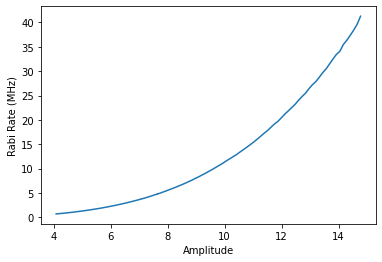

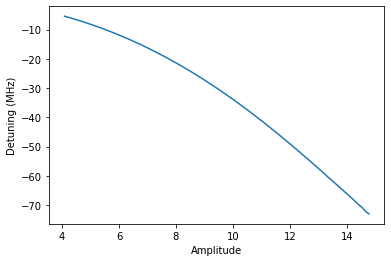

In [86]:
rabi_rates = []
rabi_amps = []
rabi_detune = []
# for j in range(0, 31):
for j in range(len(fringe2_results)):
    # print(results[j])
    # print(super_results[j+44])
    # print( (1 / (results[j]["duration"] - super_results[j+44]["duration"])) * 1000, "MHz Rabi Rate")
    rabi_rates.append((1 / (fringe2_results[j]["duration"] - super_results[j+44]["duration"])) * 1000)
    rabi_amps.append(fringe2_results[j]["amplitude"])

plt.plot(rabi_amps, rabi_rates)
plt.xlabel("Amplitude")
plt.ylabel("Rabi Rate (MHz)")
plt.show()

rabi_amps = []

# for j in range(90):
for j in range(len(fringe2_results)):
    rabi_amps.append(super_results[j]["amplitude"])
    rabi_detune.append((-super_results[j]["offset"]/(2*np.pi))*1000)

plt.plot(rabi_amps, rabi_detune)
plt.xlabel("Amplitude")
plt.ylabel("Detuning (MHz)")
plt.show()

In [96]:
fids = []
durs = []
offs = []
amps = []

for j in range(len(super_results)):
    o = super_results[j]
    if o["duration"] > 30:
        amps.append(o["amplitude"])
        durs.append(o["duration"])
        offs.append(o["offset"])
        fids.append(o["fidelity"])

fids2 = []
durs2 = []
offs2 = []
amps2 = []

for o in fringe2_results:
    if o["duration"] > 30:
        amps2.append(o["amplitude"])
        durs2.append(o["duration"])
        offs2.append(o["offset"])
        fids2.append(o["fidelity"])

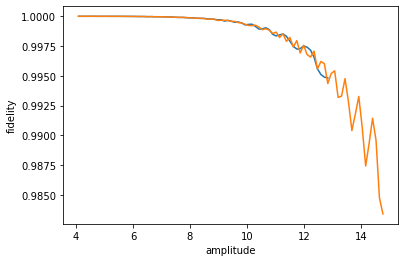

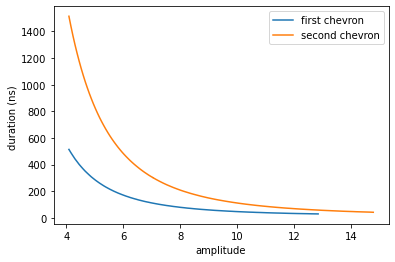

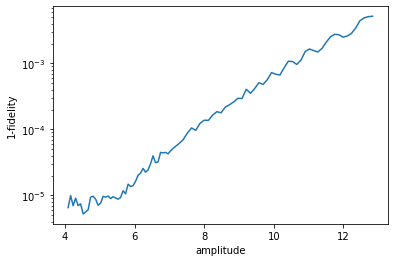

In [97]:
plt.plot(amps, fids)
plt.plot(amps2, fids2)
# plt.ylim((0, 1.1))
plt.xlabel("amplitude")
plt.ylabel("fidelity")
plt.show()
plt.plot(amps, durs, label="first chevron")
plt.plot(amps2, durs2, label="second chevron")
plt.xlabel("amplitude")
plt.ylabel("duration (ns) ")
plt.legend()
plt.show()

plt.plot(amps, 1-np.array(fids))
# plt.plot(amps2, 1-np.array(fids2))
plt.yscale("log")
plt.xlabel("amplitude")
plt.ylabel("1-fidelity")
plt.show()

# Generate Landscape

In [7]:
def inner(dur):
    global t_multiplier, amplitude, freq, ramp_slope
    tlist = np.linspace(0, dur, int(dur*t_multiplier + t_multiplier))
    tanh.setup(amplitude=amplitude, drive_frequency=freq, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    ramp_time = 16 # roughly 13, but this makes it even closer to correct
    s = fsolver.time_evolve(system.H0, system.H1, tanh, ramp_time, ramp_time, ((2*np.pi)/freq), tlist, system.starting_state)
    # s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
    fidelity = expv.expectation_value(s.states[-1], system.target_state)
    return fidelity

def generate_fidelity_landscape(_amplitude, freq_list, dur_list, _t_multiplier=5, skip_rate=1):
    global t_multiplier, amplitude, freq, ramp_slope
    t_multiplier = _t_multiplier
    amplitude = _amplitude
    fids = [] # an array of columns in the landscape
    freq_points = np.linspace(np.amin(freq_list), np.amax(freq_list), int(len(freq_list)/skip_rate))
    dur_points = np.linspace(np.amin(dur_list), np.amax(dur_list), int(len(dur_list)/skip_rate))
    for f in tqdm(freq_points):
        freq = f
        # in parallel
        fids.append(parallel_map(inner, dur_points))

        # sync
        # temp_fids = []
        # for dur in dur_points:
        #     temp_fids.append(inner(dur))
        # fids.append(temp_fids)

    fids = np.swapaxes(fids,0,1)

    plt.pcolormesh(freq_points, dur_points, fids, shading='auto')
    plt.colorbar()
    plt.xlabel("frequency (angular GHz)")
    plt.ylabel("duration (ns)")
    
    return fids

  0%|          | 0/100 [00:00<?, ?it/s]

8.001221063970204


100%|██████████| 100/100 [50:01<00:00, 30.02s/it]


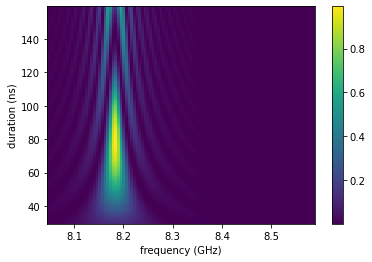

In [ ]:
import utils.floquet_solver as fsolver
import importlib
importlib.reload(fsolver)
i = 50
points_in_landscape = 100

amplitude = super_results[i]["amplitude"]
print(amplitude)
guess_time = super_results[i]["duration"]
off = super_results[i]["offset"]
freq = system.first_energy_spacing/3 - off

t_multiplier = 2
ramp_slope = 0.5
cut_factor = 3
freq_list = np.linspace(system.first_energy_spacing/3 - off*2, system.first_energy_spacing/3 + off*2, points_in_landscape)
fids0 = generate_fidelity_landscape(amplitude, freq_list, np.linspace(30, guess_time*2, points_in_landscape), t_multiplier)
plt.scatter(freq, guess_time)
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

14.046099615046595


100%|██████████| 200/200 [2:32:54<00:00, 45.87s/it]


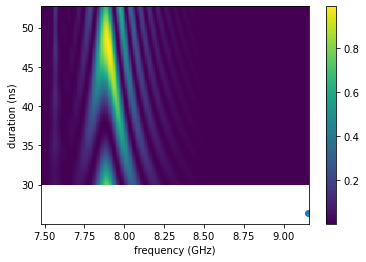

In [ ]:
import utils.floquet_solver as fsolver
import importlib
importlib.reload(fsolver)
i = 100
points_in_landscape = 200

amplitude = super_results[i]["amplitude"]
print(amplitude)
guess_time = super_results[i]["duration"]
off = super_results[i]["offset"]
guess_freq = system.first_energy_spacing/3 - off

t_multiplier = 2
ramp_slope = 0.5
cut_factor = 3
freq_list = np.linspace(system.first_energy_spacing/3 - off*2, system.first_energy_spacing/3 + off*2, points_in_landscape)
dur_list = np.linspace(30, guess_time*2, points_in_landscape)
fids0 = generate_fidelity_landscape(amplitude, freq_list, dur_list, t_multiplier)
plt.scatter(guess_freq, guess_time)
plt.show()

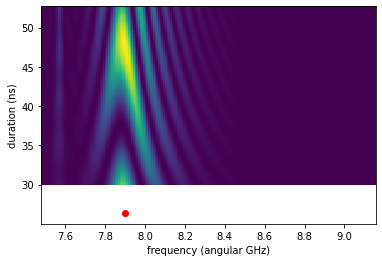

In [ ]:
# graph showing where this dot is
plt.pcolormesh(freq_list, np.linspace(30, guess_time*2, points_in_landscape), fids0, shading="auto")
plt.scatter(system.first_energy_spacing/3 - off, guess_time, c="red")
plt.xlabel("frequency (angular GHz)")
plt.ylabel("duration (ns)")
plt.show()

# Match Experiment

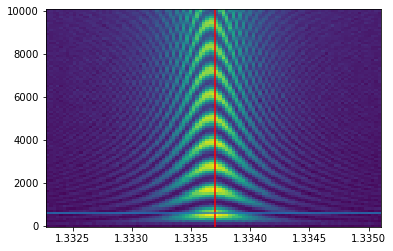

In [8]:
# create experimental graphs
experimental_amp = "0.15"
plt.pcolormesh(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experimental_amp, header=None)[0].to_list(), pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experimental_amp, header=None)[0].to_list(), -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experimental_amp, header=None).values.tolist()).transpose(), shading='auto')
plt.axvline(1.3337, c="red")
plt.axhline(600)
plt.show()

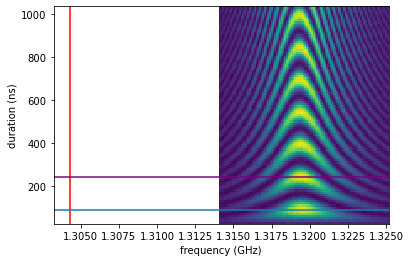

In [35]:
# create experimental graphs
experimental_amp = "0.3"
i = 47
plt.pcolormesh(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experimental_amp, header=None)[0].to_list(), pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experimental_amp, header=None)[0].to_list(), -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experimental_amp, header=None).values.tolist()).transpose(), shading='auto')
off = super_results[i]["offset"]
guess_freq = system.first_energy_spacing/3 - off
plt.axvline(guess_freq / (2*np.pi), c="red")
plt.axhline(super_results[i]["duration"])
plt.axhline(241, c="purple")
plt.ylabel("duration (ns)")
plt.xlabel("frequency (GHz)")
plt.show()

In [45]:
experimental_flist=np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experimental_amp, header=None)[0].to_list()) * (2*np.pi)
experimental_tlist=pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experimental_amp, header=None)[0].to_list()
experimental_f_distance = np.amax(experimental_flist) - np.amin(experimental_flist)

In [53]:
experimental_f_distance

0.06911503837897648

In [123]:
print(super_results[60]["amplitude"]) # 0.38
print(super_results[47]["amplitude"]) # 0.3
scaling = 0.03927458094260161
print(super_results[60]["amplitude"] * scaling) # 0.3

9.210196774185482
7.63852835090562
0.361726618705036


In [120]:
0.3/super_results[47]["amplitude"]

0.03927458094260161

In [113]:
super_results[60]["amplitude"] - super_results[47]["amplitude"]

1.5716684232798617

In [119]:
1.5716684232798617 * 12.499999999999998

19.645855290998266

  0%|          | 0/101 [00:00<?, ?it/s]

{'amplitude': 7.63852835090562, 'offset': 0.12220632682501394, 'duration': 89.75039347863529, 'fidelity': 0.9998946801469345, 'end_early': False, 'iterations': 50}


100%|██████████| 101/101 [39:55<00:00, 23.72s/it]


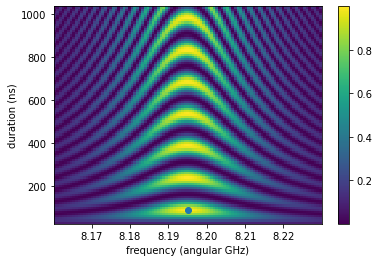

In [51]:
import utils.floquet_solver as fsolver
import importlib
importlib.reload(fsolver)
i = 47
points_in_landscape = len(experimental_tlist)

amplitude = super_results[i]["amplitude"]
guess_time = super_results[i]["duration"]
t_max = 1000
off = super_results[i]["offset"]
guess_freq = system.first_energy_spacing/3 - off
print(super_results[i])

t_multiplier = 2
ramp_slope = 0.5
cut_factor = 3
freq_list = np.linspace(guess_freq-experimental_f_distance/2, guess_freq+experimental_f_distance/2, points_in_landscape)
# dur_list = np.linspace(30, t_max, points_in_landscape)
fids_80 = generate_fidelity_landscape(amplitude, freq_list, experimental_tlist, t_multiplier)
plt.scatter(guess_freq, guess_time)
plt.show()

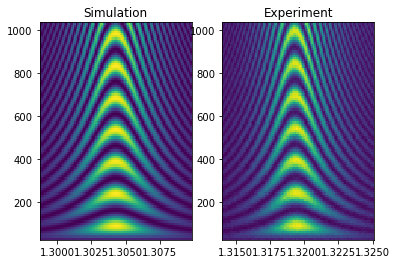

In [71]:
#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#add data to plots
axs[0].set_title("Simulation")
axs[0].pcolormesh(freq_list / (2*np.pi), experimental_tlist, fids_80, shading="auto")
axs[1].set_title("Experiment")
axs[1].pcolormesh(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experimental_amp, header=None)[0].to_list(), pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experimental_amp, header=None)[0].to_list(), -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experimental_amp, header=None).values.tolist()).transpose(), shading='auto')

plt.show()

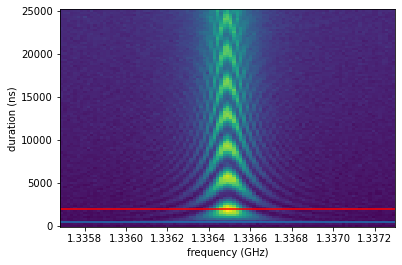

In [78]:
# create experimental graphs
experimental_amp = "0.1"
i = 0
plt.pcolormesh(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experimental_amp, header=None)[0].to_list(), pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experimental_amp, header=None)[0].to_list(), -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experimental_amp, header=None).values.tolist()).transpose(), shading='auto')
off = super_results[i]["offset"]
guess_freq = system.first_energy_spacing/3 - off
# plt.axvline(guess_freq / (2*np.pi), c="red")
plt.axhline(super_results[i]["duration"])
plt.axhline(2000, c="red")
plt.ylabel("duration (ns)")
plt.xlabel("frequency (GHz)")
plt.show()

# Make Master Plot

In [ ]:
fig, axs = plt.subplots(nrows=9, ncols=2)